In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import nltk
from nltk.corpus import stopwords
import pandas as pd
import re
from nltk.stem import WordNetLemmatizer
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import time

In [0]:
!export CUDA_LAUNCH_BLOCKING=1

In [0]:
!pip freeze --local > /content/gdrive/My\ Drive/colab_installed.txt
!pip install --upgrade wandb
!pip install --upgrade --force-reinstall `cat/content/gdrive/My\ Drive/colab_installed.txt`
!wandb login c54b2fcb6b8ca2808f5be303a8a3b6e464f52cca

In [5]:
import wandb
wandb.init(project="text-augmentation")

W&B Run: https://app.wandb.ai/msaidov/text-augmentation/runs/9wykvvf8

In [0]:
df = pd.read_json("drive/My Drive/text-augmentation/snli_1.0_train.jsonl", lines=True)

In [0]:
is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [8]:
# Drop objects with '-' label
print(df.shape, df[df["gold_label"] == "-"].shape)
df = df[df["gold_label"] != "-"]
print(df.shape)

(550152, 10) (785, 10)
(549367, 10)


In [0]:
X = pd.DataFrame(data=np.array([df["sentence1"].values, df["sentence2"].values]).transpose(), columns=["sen1", "sen2"])
y = df["gold_label"]

In [10]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

If you have file X_sen.csv, then skip to read_csv section.



In [0]:
def delete_them(w):
    if w in stopwords.words("english"):
        return ""
    return w

def stopwords_normalization(row):
    words = np.array(re.sub("[^\w]", " ",  row).split())
    sw_words = np.vectorize(delete_them)(words)
    return pd.Series(' '.join(sw_words))

In [0]:
X["sen1"] = X["sen1"].apply(stopwords_normalization)
X["sen2"] = X["sen2"].apply(stopwords_normalization)

In [0]:
X[["sen1", "sen2"]].to_csv("drive/My Drive/text-augmentation/X_sen.csv", index=False)

In [0]:
lemmatizer = WordNetLemmatizer()

def apply_lemmatization(row):
    words = np.array(re.sub("[^\w]", " ",  row.lower()).split())
    if words.shape[0] == 0:
        return pd.Series(['empty'])
    lemma_words = np.vectorize(lemmatizer.lemmatize)(words)
    return pd.Series(' '.join(lemma_words))

lemma_X = X.copy(deep=True)

start_sen1 = time.time()
lemma_X["sen1"] = X["sen1"].apply(apply_lemmatization)
end_sen1 = time.time()
print("sen1 column has been created in", end_sen1 - start_sen1, "seconds.")
start_sen2 = time.time()
lemma_X["sen2"] = X["sen2"].apply(apply_lemmatization)
end_sen2 = time.time()
print("sen2 column has been created in", end_sen2 - start_sen2, "seconds.")

In [0]:
english_stemmer = nltk.stem.snowball.EnglishStemmer()

def apply_stemming(row):
    words = row.split(' ')
    stem_words = np.vectorize(english_stemmer.stem)(words)
    return stem_words

final_X = X.copy(deep=True)
start_sen1 = time.time()
final_X["sen1"] = lemma_X["sen1"].apply(apply_stemming)
end_sen1 = time.time()
print("sen1 column has been created in", end_sen1 - start_sen1, "seconds.")
start_sen2 = time.time()
final_X["sen2"] = lemma_X["sen2"].apply(apply_stemming)
end_sen2 = time.time()
print("sen2 column has been created in", end_sen2 - start_sen2, "seconds.")

In [0]:
final_X[["sen1", "sen2"]].to_csv("drive/My Drive/text-augmentation/X_sen.csv", index=False)
X = final_X

In [0]:
# If you have X_sen.csv, code begins here.
X[["sen1", "sen2"]] = pd.read_csv("drive/My Drive/text-augmentation/X_sen.csv", index_col=False)

In [0]:
class Vocab:
    def __init__(self, min_freq=3):
        self.token_unknown = 'unk'
        self.padding = 'pad'
        self.w2i = {'unk' : 1, 'pad': 0}
        self.i2w = ['pad', 'unk']
        self.min_freq = min_freq

    def fit(self, sent_list):
        c = Counter()
        for sent in sent_list:
            c.update(str(sent))
        
        cnt = 2
        for key, val in c.items():
            if val >= self.min_freq:
                self.w2i[key] = cnt
                self.i2w.append(key)
                cnt += 1
        
    def transform(self, sen_list):
        res = []
        for sen in sen_list:
            res.append([])
            sen = str(sen)
            for w in sen:
                if not w in self.w2i:
                    res[-1].append(self.w2i[self.token_unknown])
                else:
                    res[-1].append(self.w2i[w])
        return res

In [0]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.30, random_state=1206)

In [0]:
voc = Vocab(10)
voc.fit(np.hstack((X_train['sen1'].values, X_train['sen2'].values)))

In [0]:
token1 = voc.transform(X_train['sen1'])
token2 = voc.transform(X_train['sen2'])

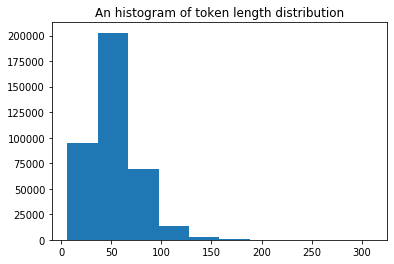

In [19]:
y_check = np.vectorize(lambda l: len(l))(np.array(token1))

plt.title("An histogram of token length distribution")
plt.hist(y_check)
plt.show()

In [21]:
start_m_one = time.time()
mx = max(y_check)
for tk in token1:
    zs = np.zeros(mx - len(tk))
    tk.extend(zs)
end_m_one = time.time()
print(f"It took {end_m_one - start_m_one} seconds to build matrix 1.")

start_m_two = time.time()
y_check_2 = np.vectorize(lambda l: len(l))(np.array(token2))
mx = max(y_check_2)
for tk in token2:
    zs = np.zeros(mx - len(tk))
    tk.extend(zs)
end_m_two = time.time()
print(f"It took {end_m_two - start_m_two} seconds to build matrix 2.")

matrix1 = np.array(token1)
matrix2 = np.array(token2)

print("Final token matrix has the following representation:")
print(matrix1)

It took 5.37647008895874 seconds to build matrix 1.
It took 4.288261651992798 seconds to build matrix 2.
Final token matrix has the following representation:
[[ 2.  3.  4. ...  0.  0.  0.]
 [16. 11.  7. ...  0.  0.  0.]
 [ 2.  3.  4. ...  0.  0.  0.]
 ...
 [ 2.  2. 19. ...  0.  0.  0.]
 [16. 11.  7. ...  0.  0.  0.]
 [16. 11.  7. ...  0.  0.  0.]]


In [0]:
y_train = LabelEncoder().fit_transform(y_train)

In [0]:
class MyDataset(Dataset):
    def __init__(self, sen_list1, sen_list2, y):
        self.sen_list1 = torch.tensor(sen_list1).long()
        self.sen_list2 = torch.tensor(sen_list2).long()
        self.y = torch.tensor(y).long()
    
    def __len__(self):
        return self.y.shape[0]
    
    def __getitem__(self, i):
        return (self.sen_list1[i], self.sen_list2[i], self.y[i])

In [0]:
dataset = MyDataset(matrix1, matrix2, y_train)

loader = DataLoader(dataset, batch_size=10, shuffle=True)

criterion = nn.CrossEntropyLoss()

In [0]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.embeddings = nn.Embedding(len(voc.i2w), 100)
        self.rnn = nn.GRU(100, 128, batch_first=True)
        self.linear = nn.Linear(128 * 2, 3)
    
    def forward(self, x1, x2):
        e1 = self.embeddings(x1)
        e2 = self.embeddings(x2)
        _, res1 = self.rnn(e1)
        _, res2 = self.rnn(e2)
        res = torch.cat([res1, res2], dim=2)
        res = res.squeeze(0)
        ans = self.linear(res)
        return ans

In [0]:
model = Model()
optimizer = torch.optim.Adam(model.parameters())

In [0]:
model = model.cuda()
criterion = criterion.cuda()

In [43]:
n_epochs = 2
log_interval = 50
n_correct, n_total, n_loss = 0, 0, 0
for epoch in range(1, n_epochs + 1):
    print("Epoch number:", epoch)
    batch_idx = 0
    for x1_batch, x2_batch, y_batch in loader:
        batch_idx += 1
        x1_batch = x1_batch.cuda()
        x2_batch = x2_batch.cuda()
        y_batch = y_batch.cuda()
        optimizer.zero_grad()
        logit = model(x1_batch, x2_batch)
        loss = criterion(logit, y_batch)
        loss.backward()
        optimizer.step()
        n_total += y_batch.shape[0]
        n_correct += (torch.max(logit, 1)[1].view(y_batch.shape[0]) == y_batch).sum().item()
        n_loss += loss.item()
        
        if batch_idx % log_interval == 0:
            val_loss = n_loss / n_total
            val_acc = 100. * n_correct / n_total
            wandb.log({"Train Accuracy": val_acc, "Train Loss": val_loss})

val_loss = n_loss / n_total
val_acc = 100. * n_correct / n_total
print("Current train accuracy:", val_acc)
print("Current train loss:", val_loss)

Epoch number: 1
Epoch number: 2
Current train accuracy: 33.24743340371754
Current train loss: 0.11043667323279531
